Import Packages

In [2]:
using Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("LaTeXStrings")
Pkg.add("Random")
Pkg.add("ColorSchemes")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Constants

$\Gamma_0 = 1$

$\Gamma_c = 5\Gamma_0$

In [3]:
Γ_0 = 1
Γ_c = 5Γ_0

5

Operators

$\sigma_- = \ket{g}\bra{e} = \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}$

$\sigma_+ = \ket{e}\bra{g} = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}$

In [4]:
σ_m = Matrix([0 1; 0 0])
σ_p = Matrix([0 0 ; 1 0])

2×2 Matrix{Int64}:
 0  0
 1  0

Initial Conditions

$\ket{\psi(t=0)} = \ket{e} = \begin{pmatrix} 0 \\ 1 \end{pmatrix}$

$\rho(t=0) = \ket{\psi(0)}\bra{\psi(0)} = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix}$

In [5]:
ψ_0 = [0.0;1.0]
ρ_0 = ψ_0*ψ_0'

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  1.0

Master Equation

$\dot{\rho} = \frac{\Gamma_c + \Gamma_0}{2}(2\sigma_- \rho \sigma_+ - \sigma_+\sigma_-\rho + \rho\sigma_+\sigma_-)$

In [6]:
function master_equation!(dρ, ρ, u, t)
    dρ[:, :] = (Γ_c + Γ_0)/(2) .* (2 .* (σ_m * ρ * σ_p) - (σ_p * σ_m * ρ) - (ρ * σ_p * σ_m))
end

master_equation! (generic function with 1 method)

Solving Master Equation

In [7]:
using DifferentialEquations
t_span = (0.,1.0)
prob = ODEProblem(master_equation!, ρ_0, t_span)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 46-element Vector{Float64}:
 0.0
 0.0054859835078359094
 0.011785360841145263
 0.019679342642316043
 0.028642926146579567
 0.03888453452030125
 0.05015394730679074
 0.062449678774986465
 0.07563105501531898
 0.0896415079934567
 ⋮
 0.7131504122458288
 0.7456768803904045
 0.779346304088579
 0.8142398227795343
 0.8504469572752704
 0.8880667896905393
 0.927209998213014
 0.9679991005022933
 1.0
u: 46-element Vector{Matrix{Float64}}:
 [0.0 0.0; 0.0 1.0]
 [0.032380068009452076 0.0; 0.0 0.967619931990548]
 [0.06826996199311516 0.0; 0.0 0.9317300380068849]
 [0.11137153535150679 0.0; 0.0 0.8886284646484933]
 [0.15790088414648754 0.0; 0.0 0.8420991158535126]
 [0.2080897443143666 0.0; 0.0 0.7919102556856336]
 [0.2598657451966299 0.0; 0.0 0.7401342548033703]
 [0.3125031784339134 0.0; 0.0 0.6874968215660867]
 [0.36478155416312025 0.0; 0.0 0.6352184458368798]
 [0.4159969350122385 0.0; 0.0 0.5840030649877616]
 ⋮
 [0.98614213

Finding $<\sigma_{ee}>$

$\sigma_{ee} = \begin{pmatrix} 0 && 0 \\ 0 && 1 \end{pmatrix}$

$<\sigma_{ee}(t)> = Tr(\rho(t)\sigma_{ee})$

In [8]:
using LinearAlgebra

# initializing 
σ_ee = Matrix([0 0 ; 0 1])
ρ = sol.u
time_arr_num = sol.t

time_size = size(ρ)[1]
σ_ee_exp = zeros(time_size)

# taking trace over each time step to get expectation value for each time step
for t in 1:time_size
    σ_ee_exp[t] = tr(σ_ee * ρ[t])
end

Plotting Results for 1a

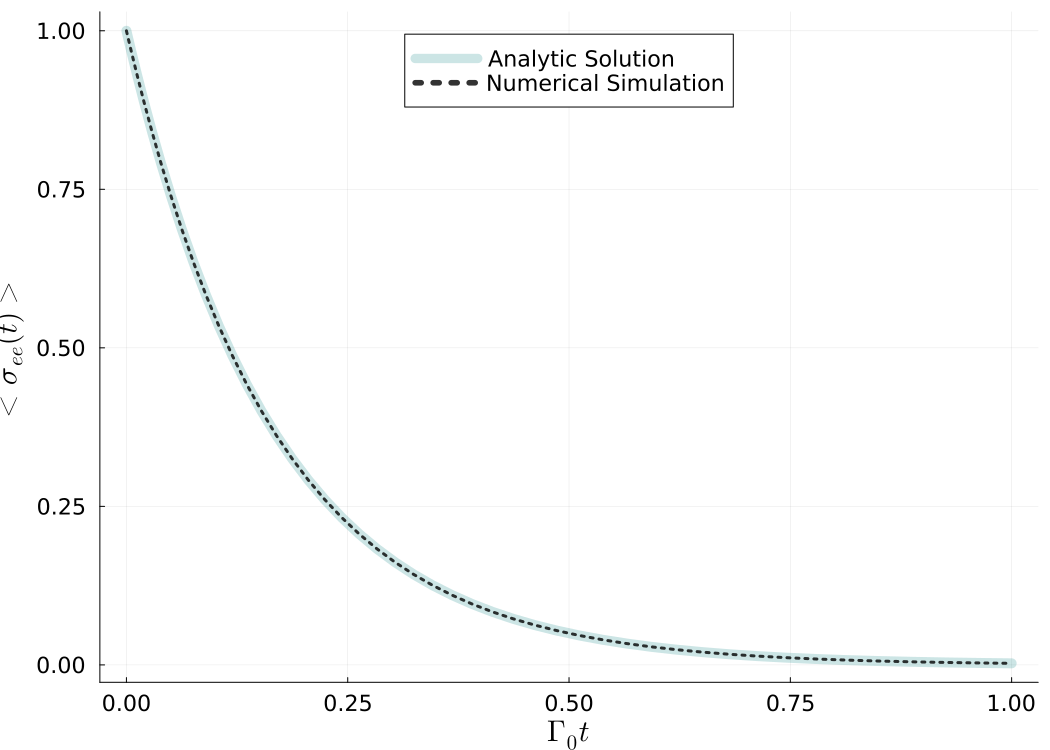

In [9]:
using Plots
using LaTeXStrings

σ_ee_exp_analytic = exp.(-(Γ_0 + Γ_c)*time_arr_num)

plot(time_arr_num, σ_ee_exp_analytic, label = "Analytic Solution", labelfontsize = 20, color=:teal, linewidth=10, alpha=0.2, legend=false)

labels = L"<\sigma_{ee}>"
plot!(time_arr_num, σ_ee_exp, label = "Numerical Simulation", labelfontsize = 20, color=:black, linewidth = 3, linestyle=:dot, alpha = .8)

xlabel!(L"\Gamma_0 t", fontsize = 15)
ylabel!(L"<\sigma_{ee}(t)>", fontsize = 15)
plot!(legend=:top, legendfontsize = 15, xtickfontsize=15, ytickfontsize=15)
plot!(size=(1050,750))

# Quantum Trajectories

First order approximation of evolution with non-Hermitian Hamiltonian $H_{eff}$

$\ket{\psi^1(t+\delta t)} = (1 - iH_{eff}\delta t)(\ket{\psi (t)})$

To continuously normalize evolution

$\braket{\psi^1(t+\delta t)|\psi^1(t+ \delta t)} = \bra{\psi(t)}(1 + iH_{eff}\delta t)(1 - iH_{eff}\delta t)\ket{\psi(t)} = 1 - \delta p$

where, $\delta p = \delta t \sum_{m}\bra{\psi(t)}c^{\dagger}_{m}c_{m}\ket{\psi(t)} \equiv \sum_{m}\delta p_{m}$

The interpretation is that $\delta p_m$ is the probability of the action descibed by $c_m$ occuring in that time step

In this problem with 1 atom approximated by 2 level system $H_{eff}$ is

$H_{eff} = -\frac{i}{2} (\Gamma_0 + \Gamma_c)(\sigma_{+}\sigma_{-})$

Defining simulation parameters

In [10]:
time_steps = 1000
δt = .001
trajectories = 1000

1000

Defining operators

In [11]:
using LinearAlgebra
H_eff = -1im/2 .* (Γ_0+Γ_c) .* (σ_p * σ_m)
Id = Matrix{Float64}(I, 2, 2)
time_arr_traj = [δt * i for i in 0:time_steps-1]

1000-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009000000000000001
 ⋮
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999

Iterative process of calculating quantum trajectories

In [12]:
expec_avg = [0.0 for i in 1:time_steps]

for a in 1:trajectories
    expec = [0.0 for i in 1:time_steps]

    # Storing wavevector in matrix (2 by time_steps) with initial time set to excited state [0,1]
    ψ = [0.0 for i in 1:time_steps, j in 1:2]; ψ[1,:] = ψ_0

    for t in 1:time_steps-1

        # Calculating first order of wavefunction after a time step
        first_order = (Id - 1im .* H_eff .* δt) * ψ[t,:]
    
        # Calculating probability of jump operator acting within time step
        δp = δt * (ψ[t,:]' * ((Γ_c+Γ_0) .* (σ_p * σ_m)) * ψ[t,:])
    
        # Generating random number to determine action within time step
        r = rand(Float64)
    
        # Updating wavevector based on result of r
        if r > δp
            ψ[t+1,:] = first_order / (1-δp)^(1/2)
        else
            ψ[t+1,:] = (Γ_0+Γ_c)^(1/2) .* σ_m * (ψ[t,:]) / (δp/δt)^(1/2)
        end
    
        # Updating expectation value for each time step
        expec[t] = ψ[t,:]' * σ_ee * ψ[t,:]
        expec_avg[t] = expec_avg[t] + expec[t]
    end
end
expec_avg = expec_avg ./ trajectories


1000-element Vector{Float64}:
 1.0
 0.9910089728370052
 0.9840178727745309
 0.9770266989873734
 0.9710354871900221
 0.965044218546098
 0.9560527269153831
 0.9490612498299292
 0.9430697687686904
 0.9360781443911795
 ⋮
 0.0023688016618056557
 0.002388558296218186
 0.002408769359692156
 0.0024294503356344613
 0.0024506174185334817
 0.0024722875552582848
 0.0024944784892700226
 0.0025172088079879686
 0.0

In [13]:
trajectories = [5, 50, 500, 5000]
expec_avg_arr = [zeros(1000) for _ in 1:length(trajectories)]

# First loop repeats same process for different number of trajectories

for i in 1:length(trajectories)
    expec_avg = [0.0 for i in 1:time_steps]
    for a in 1:trajectories[i]
        expec = [0.0 for i in 1:time_steps]
    
        # Storing wavevector in matrix (2 by time_steps) with initial time set to excited state [0,1]
        ψ = [0.0 for i in 1:time_steps, j in 1:2]; ψ[1,:] = ψ_0
    
        for t in 1:time_steps-1
    
            # Calculating first order of wavefunction after a time step
            first_order = (Id - 1im .* H_eff .* δt) * ψ[t,:]
        
            # Calculating probability of jump operator acting within time step
            δp = δt * (ψ[t,:]' * ((Γ_c+Γ_0) .* (σ_p * σ_m)) * ψ[t,:])
        
            # Generating random number to determine action within time step
            r = rand(Float64)
        
            # Updating wavevector based on result of r
            if r > δp
                ψ[t+1,:] = first_order / (1-δp)^(1/2)
            else
                ψ[t+1,:] = (Γ_0+Γ_c)^(1/2) .* σ_m * (ψ[t,:]) / (δp/δt)^(1/2)
            end
        
            # Updating expectation value for each time step
            expec[t] = ψ[t,:]' * σ_ee * ψ[t,:]
            expec_avg[t] = expec_avg[t] + expec[t]
        end
    end
    expec_avg = expec_avg ./ trajectories[i]
    expec_avg_arr[i] = expec_avg

end

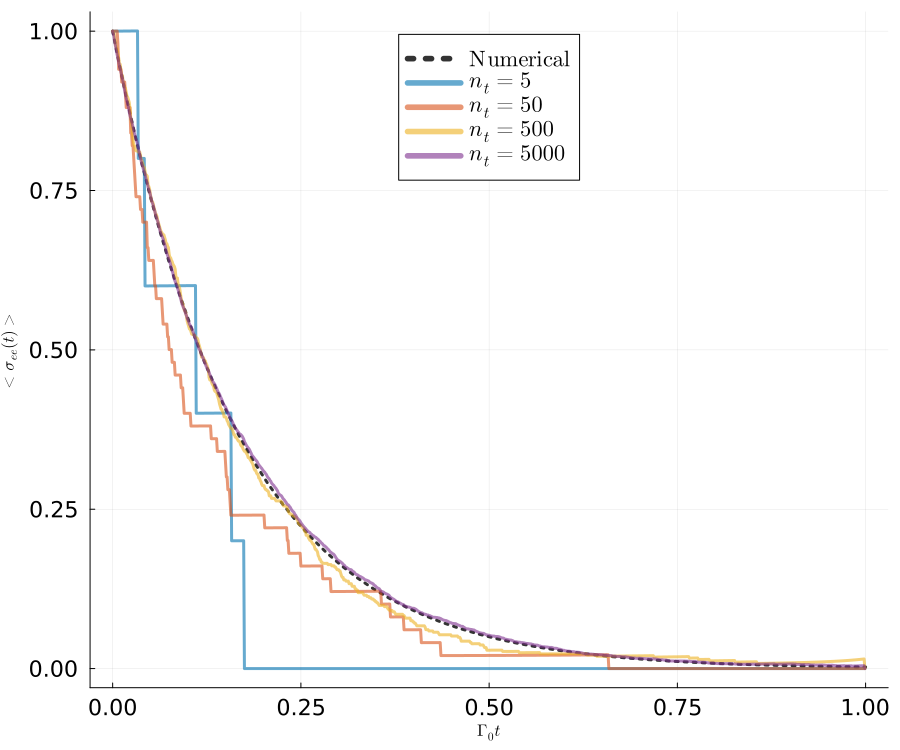

In [14]:
using Plots
using LaTeXStrings

my_colors = [
    RGB(0.0, 0.447, 0.69),
    RGB(0.85, 0.325, 0.098),
    RGB(0.929, 0.694, 0.125),
    RGB(0.494, 0.184, 0.556)
]

plot(time_arr_num, σ_ee_exp, linestyle=:dot, label = L"\textnormal{Numerical}", color=:black, linewidth=3, alpha=0.8)
labels = [L"n_t = 5", L"n_t = 50", L"n_t = 500", L"n_t = 5000"]

for i in 1:length(trajectories)
    plot!(time_arr_traj, expec_avg_arr[i], linewidth=3, color=my_colors[i], alpha=0.6, label=labels[i])
end

xlabel!(L"\Gamma_0 t", fontsize=30)
ylabel!(L"<\sigma_{ee}(t)>", fontsize=30)
plot!(legend=:top, legendfontsize=15, xtickfontsize=15, ytickfontsize=15)
plot!(size=(900, 750))

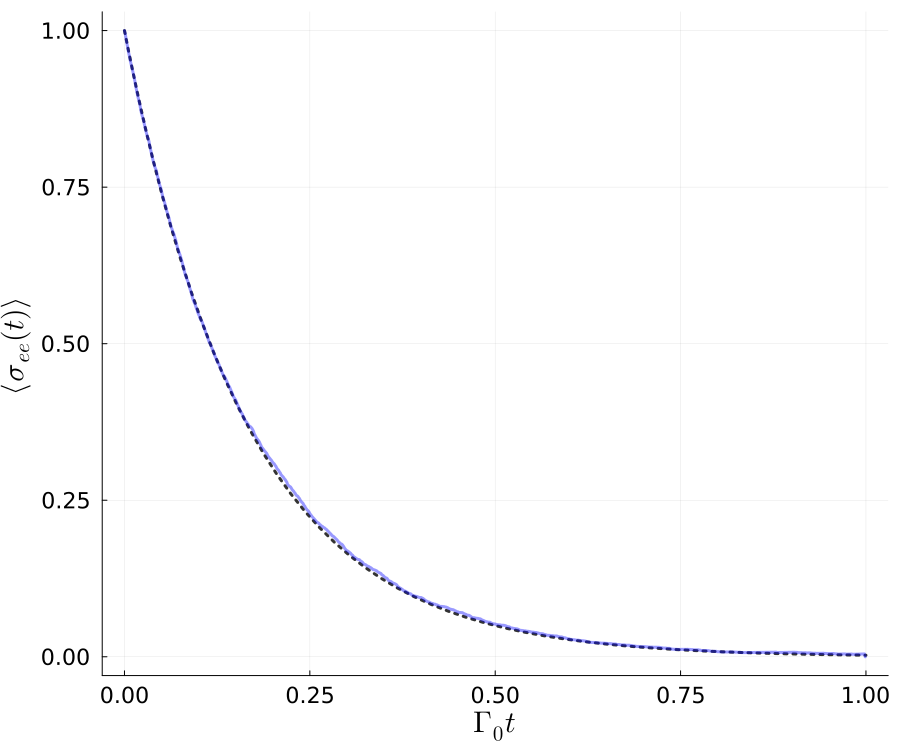

In [15]:
using LaTeXStrings
plot(time_arr_num, σ_ee_exp, linestyle=:dot, labelfontsize = 20, color=:black, linewidth = 3, alpha = .8, legend = false)
plot!(time_arr_traj, expec_avg_arr[4], linewidth = 3, color =:blue, alpha = .4, legend = false)
xlabel!(L"\Gamma_0 t", fontsize = 40)
ylabel!(L"$\langle \sigma_{ee}(t) \rangle$", fontsize = 40)
plot!(xtickfontsize=15, ytickfontsize=15)
plot!(size=(900,750))
#savefig("img2_4")

## Atoms in a Cavity

Defining parameters and operators

In [131]:
using LinearAlgebra

num_atoms = 5
Γ_0 = 1.
Γ_c = 2.

# Defining state and density matrix as fully excited
ψ_e = [0,1]
ψ_0 = ψ_e
for i in 1:num_atoms-1
    ψ_0 = kron(ψ_0,ψ_e)
end
ρ_0 = ψ_0 * ψ_0'

# Defining raising and lowering operators for each corresponding atom number and storing in a single tensor (N dim Vector of 2N*2N Matrices)
σ_m = Matrix([0 1; 0 0])
σ_p = Matrix([0 0 ; 1 0])
σ_ee = Matrix([0 0 ; 0 1])
Id = [1 0; 0 1]

# Initializing raising and lowering operators for all 
σ_m_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
σ_p_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
σ_ee_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]

# Changing the matrix for corresponding n to be a jump operator for the nth atom
σ_m_hold = Id
σ_p_hold = Id
σ_ee_hold = Id

for n in 1:num_atoms
    
    for a in 1:num_atoms
        
        if (a == 1) && (n == 1)
            σ_m_hold = σ_m
            σ_p_hold = σ_p
            σ_ee_hold = σ_ee
        
        elseif (a == 1) && (n != 1)
            σ_m_hold = Id
            σ_p_hold = Id
            σ_ee_hold = Id

        elseif (a != 1) && (n == a)
            σ_m_hold = kron(σ_m_hold, σ_m)
            σ_p_hold = kron(σ_p_hold, σ_p)
            σ_ee_hold = kron(σ_ee_hold, σ_ee)
        
        else
            σ_m_hold = kron(σ_m_hold, Id)
            σ_p_hold = kron(σ_p_hold, Id)
            σ_ee_hold = kron(σ_ee_hold, Id)
        end

    end
    σ_m_n[n] = σ_m_hold
    σ_p_n[n] = σ_p_hold
    σ_ee_n[n] = σ_ee_hold
end

gamma_matrix = (Γ_c .* ones(num_atoms, num_atoms)) .+ (Γ_0 .* Matrix{Float64}(I, num_atoms, num_atoms))

5×5 Matrix{Float64}:
 3.0  2.0  2.0  2.0  2.0
 2.0  3.0  2.0  2.0  2.0
 2.0  2.0  3.0  2.0  2.0
 2.0  2.0  2.0  3.0  2.0
 2.0  2.0  2.0  2.0  3.0

Defining master equation

In [132]:
function master_equation!(dρ, ρ, u, t)
    d_hold = zeros(size(dρ))
    for i in 1:num_atoms
        for j in 1:num_atoms
            d_hold[:,:] = d_hold[:,:] + ((1/2) .* gamma_matrix[i,j] .* (2 .* σ_m_n[j] * ρ * σ_p_n[i] - σ_p_n[i] * σ_m_n[j] * ρ - ρ * σ_p_n[i] * σ_m_n[j]))
        end
    end
    dρ[:,:] = d_hold
end

master_equation! (generic function with 1 method)

Solving master equation

In [133]:
using DifferentialEquations
t_span = (0.,1.0)
prob = ODEProblem(master_equation!, ρ_0, t_span)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 54-element Vector{Float64}:
 0.0
 0.0058956718985173195
 0.009067208068847489
 0.014073390205283899
 0.018523939080806923
 0.023774668707871503
 0.02906939385462398
 0.0348189836731257
 0.04079366195754839
 0.04712287586240471
 ⋮
 0.6525466691763446
 0.6902766300009032
 0.7310724577931502
 0.774590608239136
 0.8203606325936103
 0.8684194584639574
 0.9190208635402536
 0.9725760284989455
 1.0
u: 54-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0]
 [4.123489110779865e-8 0.0 … 0.0 0.0; 0.0 6.945271019416735e-7 … 0.0 0.0; … ; 0.0 0.0 … 0.016081008653017294 0.0; 0.0 0.0 … 0.0 0.9153625355652361]
 [3.413604911056531e-7 0.0 … 0.0 0.0; 0.0 3.6878785008971475e-6 … 0.0 0.0; … ; 0.0 0.0 … 0.02349947708993523 0.0; 0.0 0.0 … 0.0 0.8728355441621664]
 [2.8686777058701003e-6 0.0 … 0.0 0.0; 0.0 1.97203392472687e-5 … 0.0 0.0; … ; 0.0 0.0 … 0.03365205040798906 0.0

Taking trace to find expectation value of total excitations over time

$<\sum_i \sigma_{ee}^{i}> = Tr(\sum_i \rho\sigma_{ee}^{i})$

In [134]:
ρ = sol.u
time_arr_num = sol.t

σ_ee_exp_num = zeros(length(time_arr_num))

σ_ee_sum = zeros(2^num_atoms,2^num_atoms)
for n in 1:num_atoms
    σ_ee_sum += σ_ee_n[n]
end

# Taking trace of the sum for each time step
for t in 1:length(time_arr_num)
    σ_ee_exp_num[t] = tr(ρ[t] * σ_ee_sum)
end

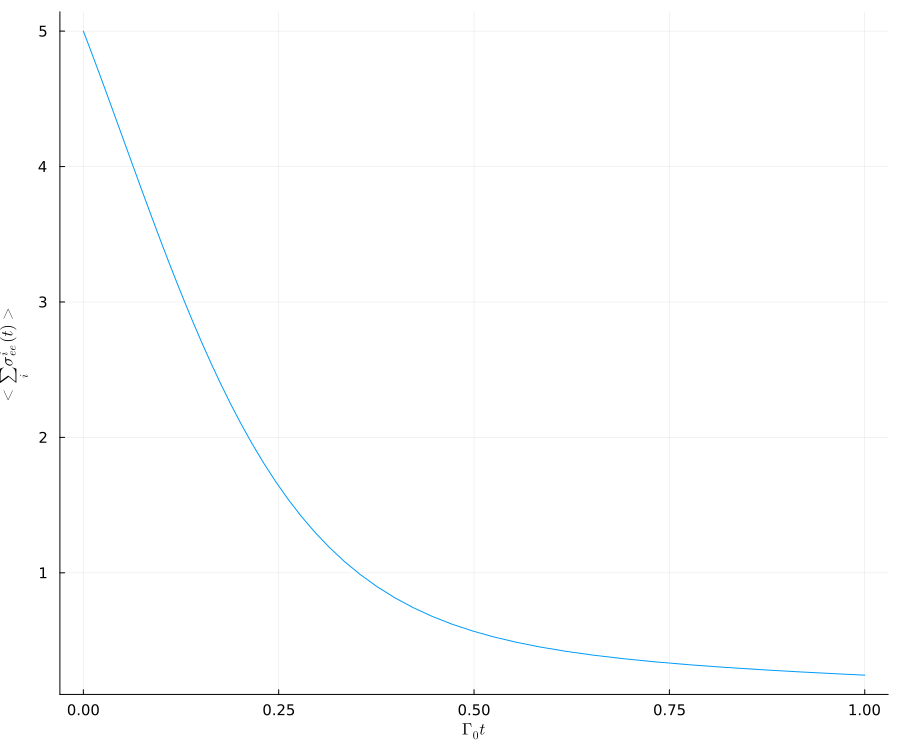

In [135]:
using Plots
using LaTeXStrings

plot(time_arr_num, σ_ee_exp_num)

xlabel!(L"\Gamma_0 t", fontsize=15)
ylabel!(L"<\sum_i \sigma_{ee}^i(t)>", fontsize=15)
plot!(legend = false, xtickfontsize=10, ytickfontsize=10)
plot!(size=(900, 750))

#savefig("img3_4")

Calculating Rate of Change

In [55]:
dR = -1 .* diff(σ_ee_exp)
dt = diff(time_arr)
time_arr_burst = time_arr[1:end-1]

ROC = dR ./ dt

57-element Vector{Float64}:
 11.83937670386274
 11.552196571738142
 11.252878606320735
 10.911943375404762
 10.553430920315849
 10.172139769653011
  9.779296233853149
  9.376471309175514
  8.969521536452396
  8.561080474563564
  ⋮
  0.18884816371088095
  0.15466807110977157
  0.12580710488830057
  0.1016371824712491
  0.08154024242787204
  0.06494015947338859
  0.05131700989964707
  0.04021088598677001
  0.03419467195296322

Plotting Rate of Change

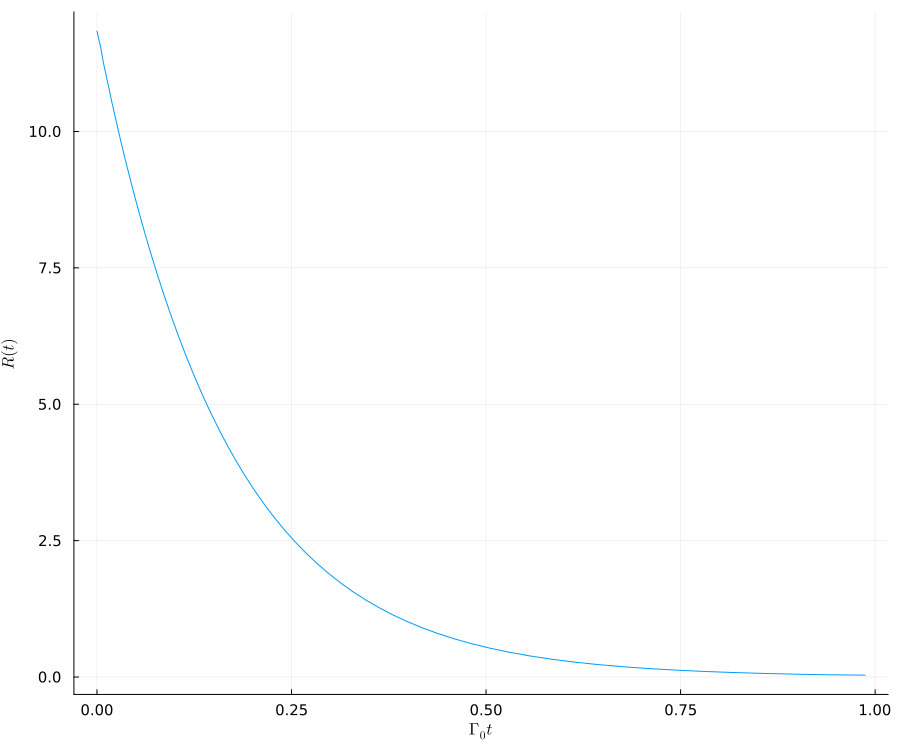

In [56]:
using Plots

plot(time_arr_burst, ROC)
xlabel!(L"\Gamma_0 t", fontsize=100)
ylabel!(L"R(t)", fontsize=100)
plot!(legend = false, xtickfontsize=10, ytickfontsize=10)
plot!(size=(900, 750))
#savefig("img5_4")

## Quantum Trajectories for Multiple Atoms in a Cavity

Solving Eigenvalue/Eigenvector problem to find operators

In [151]:
using LinearAlgebra

# Defining matrix (NxN) holding values of decay rates
num_atoms = 5
Γ_0 = 1.
Γ_c = 2.

# Defining raising and lowering operators for each corresponding atom number and storing in a single tensor (N dim Vector of 2N*2N Matrices)
σ_m = Matrix([0 1; 0 0])
σ_p = Matrix([0 0 ; 1 0])
σ_ee = Matrix([0 0 ; 0 1])
Id = [1 0; 0 1]

# Initializing raising and lowering operators for all 
σ_m_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
σ_p_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
σ_ee_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
c = [Matrix{Float64}(zeros(2^num_atoms, 2^num_atoms)) for _ in 1:num_atoms]

# Changing the matrix for corresponding n to be a jump operator for the nth atom
σ_m_hold = Id
σ_p_hold = Id
σ_ee_hold = Id

for n in 1:num_atoms
    
    for a in 1:num_atoms
        
        if (a == 1) && (n == 1)
            σ_m_hold = σ_m
            σ_p_hold = σ_p
            σ_ee_hold = σ_ee
        
        elseif (a == 1) && (n != 1)
            σ_m_hold = Id
            σ_p_hold = Id
            σ_ee_hold = Id

        elseif (a != 1) && (n == a)
            σ_m_hold = kron(σ_m_hold, σ_m)
            σ_p_hold = kron(σ_p_hold, σ_p)
            σ_ee_hold = kron(σ_ee_hold, σ_ee)
        
        else
            σ_m_hold = kron(σ_m_hold, Id)
            σ_p_hold = kron(σ_p_hold, Id)
            σ_ee_hold = kron(σ_ee_hold, Id)
        end

    end
    σ_m_n[n] = σ_m_hold
    σ_p_n[n] = σ_p_hold
    σ_ee_n[n] = σ_ee_hold
end

σ_ee_sum = zeros(2^(num_atoms), 2^(num_atoms))
for n in 1:num_atoms
    σ_ee_sum += σ_ee_n[n]
end

gamma_matrix = (Γ_c .* ones(num_atoms, num_atoms)) .+ (Γ_0 .* Matrix{Float64}(I, num_atoms, num_atoms))

eig_vals = eigvals(gamma_matrix)
eig_vecs = eigvecs(gamma_matrix)

# Defining diagonalized operators
for m in 1:num_atoms
    for n in 1:num_atoms
        c[m] += eig_vecs[n,m] .* σ_m_n[n]
    end
end

# Defining H_eff
H_eff = zeros(2^(num_atoms), 2^(num_atoms))

for m in 1:num_atoms
    H_eff += (-1im .* eig_vals[m] .* c[m]' * c[m])/2
end

println(eig_vals)

[0.9999999999999996, 1.0, 1.0, 1.0, 11.0]


In [152]:
using LinearAlgebra

# Defining raising and lowering operators for each corresponding atom number and storing in a single tensor (N dim Vector of 2N*2N Matrices)
σ_m = Matrix([0 1; 0 0])
σ_p = Matrix([0 0 ; 1 0])
σ_ee = Matrix([0 0 ; 0 1])
Id = [1 0; 0 1]

# Initializing raising and lowering operators for all 
σ_m_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
σ_p_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
σ_ee_n = [Matrix{Float64}(I, 2^num_atoms, 2^num_atoms) for _ in 1:num_atoms]
c = [Matrix{Float64}(zeros(2^num_atoms, 2^num_atoms)) for _ in 1:num_atoms]

# Changing the matrix for corresponding n to be a jump operator for the nth atom
σ_m_hold = Id
σ_p_hold = Id
σ_ee_hold = Id

for n in 1:num_atoms
    
    for a in 1:num_atoms
        
        if (a == 1) && (n == 1)
            σ_m_hold = σ_m
            σ_p_hold = σ_p
            σ_ee_hold = σ_ee
        
        elseif (a == 1) && (n != 1)
            σ_m_hold = Id
            σ_p_hold = Id
            σ_ee_hold = Id

        elseif (a != 1) && (n == a)
            σ_m_hold = kron(σ_m_hold, σ_m)
            σ_p_hold = kron(σ_p_hold, σ_p)
            σ_ee_hold = kron(σ_ee_hold, σ_ee)
        
        else
            σ_m_hold = kron(σ_m_hold, Id)
            σ_p_hold = kron(σ_p_hold, Id)
            σ_ee_hold = kron(σ_ee_hold, Id)
        end

    end
    σ_m_n[n] = σ_m_hold
    σ_p_n[n] = σ_p_hold
    σ_ee_n[n] = σ_ee_hold
end

σ_ee_sum = zeros(2^(num_atoms), 2^(num_atoms))
for n in 1:num_atoms
    σ_ee_sum += σ_ee_n[n]
end

gamma_matrix = (Γ_c .* ones(num_atoms, num_atoms)) .+ (Γ_0 .* Matrix{Float64}(I, num_atoms, num_atoms))

eig_vals = eigvals(gamma_matrix)
eig_vecs = eigvecs(gamma_matrix)

# Defining diagonalized operators
for m in 1:num_atoms
    for n in 1:num_atoms
        c[m] += eig_vecs[n,m] .* σ_m_n[n]
    end
end

# Defining H_eff
H_eff = zeros(2^(num_atoms), 2^(num_atoms))

for m in 1:num_atoms
    H_eff += (-1im .* eig_vals[m] .* c[m]' * c[m])/2
end

println(eig_vals)

[0.9999999999999996, 1.0, 1.0, 1.0, 11.0]


Calculating Quantum Trajectories

In [153]:
time_steps = 1000
δt = .001
trajectories = 5
Id = Matrix{Float64}(I, 2^(num_atoms), 2^(num_atoms))
ψ_e = [0,1]
ψ_0 = ψ_e

for i in 1:num_atoms-1
    ψ_0 = kron(ψ_0,ψ_e)
end

expec_avg = [0.0 for i in 1:time_steps]
δp_m = [0.0 for _ in 1:num_atoms]

for a in 1:trajectories
    expec = [0.0 for i in 1:time_steps]

    # Storing wavevector in matrix (2 by time_steps) with initial time set to excited state [0,1]
    ψ = Complex[0.0 for i in 1:time_steps, j in 1:2^(num_atoms)]; ψ[1,:] = ψ_0

    for t in 1:time_steps-1
        # Calculating first order of wavefunction after a time step
        first_order = (Id - 1im .* H_eff .* δt) * ψ[t,:]
        
        # Calculating probability of jump operator acting within time step
        δp = 0.0
        δp_m = [0.0 for _ in 1:num_atoms]
        for m in 1:num_atoms
            δp_m[m] = real(δt * (ψ[t,:]' * (eig_vals[m] * c[m]' * c[m]) * ψ[t,:]))
            δp += δp_m[m]
        end
        
        # Generating random number to determine action within time step
        r = rand(Float64)

        # Updating wavevector based on result of r
        if r >= δp
            ψ[t+1,:] = first_order / (1-δp)^(1/2)

        else
            # Generating new random number to determine which jump operator to use
            r = rand(Float64)

            # Normalizing δp_m
            δp_norm_const = 1/(sum(δp_m))
            δp_norm = δp_norm_const .* δp_m

            m_count = 0
            p_count = 0
            while p_count <= r
                m_count += 1
                p_count += δp_norm[m_count]
                if p_count > r
                    ψ[t+1,:] = (eig_vals[m_count])^(1/2) .* c[m_count] * (ψ[t,:]) / (δp_m[m_count]/δt)^(1/2)
                end
            end
        end

        # Updating expectation value for each time step
        expec[t] = real(ψ[t,:]' * σ_ee_sum * ψ[t,:])
        expec_avg[t] = real(expec_avg[t] + expec[t])

    end
end

expec_avg = expec_avg ./ trajectories

1000-element Vector{Float64}:
 5.0
 5.000285532994925
 5.000575431014284
 5.00086976130329
 5.001168592158938
 5.0014719929469305
 5.001780034118912
 5.002092787229978
 5.002410324956502
 5.0027327211142305
 ⋮
 0.6009967941043992
 0.6009991840698593
 0.6010015786845168
 0.6010039779578713
 0.6010063818994407
 0.6010087905187597
 0.6010112038253828
 0.6010136218288824
 0.0

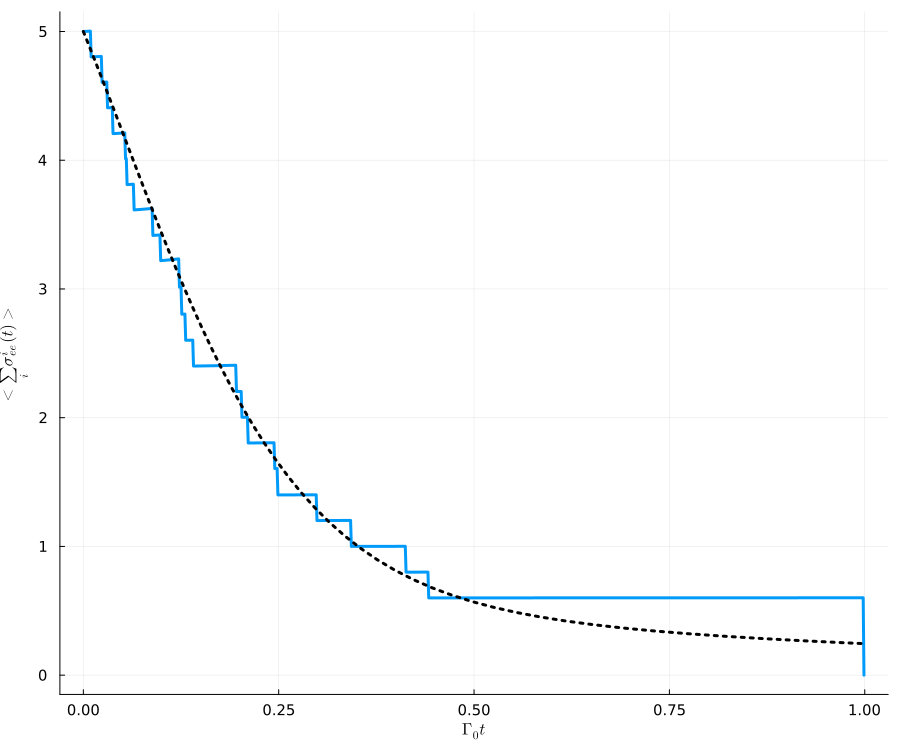

In [154]:
time_arr = [ (n-1)*δt for n in 1:time_steps ]
plot(time_arr, expec_avg, linewidth=3)
plot!(time_arr_num, σ_ee_exp_num, linewidth=3, linestyle=:dot, color=:black)
xlabel!(L"\Gamma_0 t", fontsize=15)
ylabel!(L"<\sum_i \sigma_{ee}^i(t)>", fontsize=15)
plot!(legend = false, xtickfontsize=10, ytickfontsize=10)
plot!(size=(900, 750))
#savefig("img6_9")